# Détection d'anomalie

**IMPORTANT** : Créez une ressource *Détecteur d'anomalies* ou *Anomaly detector* et renseignez `SERVEUR` avec votre point de terminaison (endpoint). Récupérez également la clé et renseignez là lors de l'exécution de la première cellule.

Dans cet exemple, nous utilisons les données de comptage routier, mesurées sur un tronçon de route spécifique [opendata.paris.fr](https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents/information/).

In [1]:
from getpass import getpass

CLE = getpass()
SERVEUR = 'https://anomaly00.cognitiveservices.azure.com/'

## Chargement des données

In [3]:
import json 
 
with open('data.json') as f:
    data = json.load(f)

## Envoi à l'API

In [4]:
import requests

reponse = requests.post(
  url = f'{SERVEUR}/anomalydetector/v1.0/timeseries/entire/detect',
  headers = {
    'Ocp-Apim-Subscription-Key': CLE,
    'Content-Type': 'application/json'
  },
  json = data
)
result = reponse.json()

## Traitement des résultats

In [5]:
import pandas as pd

trafic = pd.DataFrame.from_dict(data['series'])
trafic['attendu'] = result['expectedValues']
trafic['timestamp'] = pd.to_datetime(trafic['timestamp'])
trafic['anomalie'] = [data['series'][i]['value'] if result['isAnomaly'][i] else None for i in range(len(result['isAnomaly']))]

trafic.index = trafic['timestamp']
del trafic['timestamp']

## Tracé

In [14]:
%matplotlib inline

<Axes: xlabel='timestamp'>

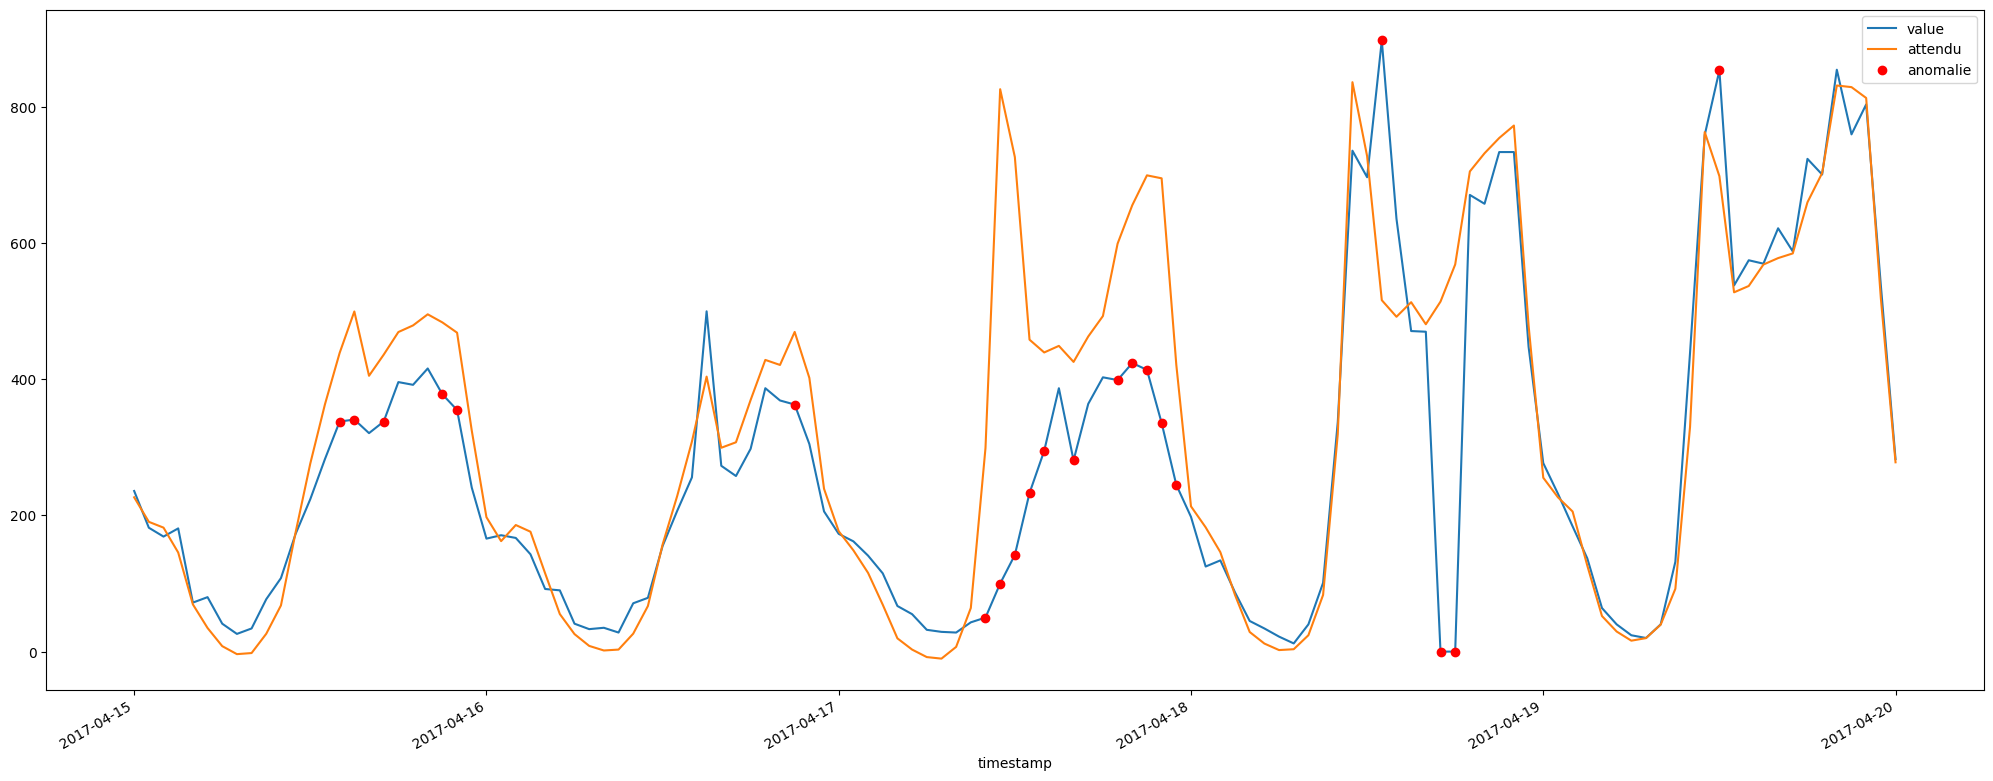

In [34]:
def d(s):
    return pd.Timestamp(s).tz_localize('Europe/Paris')

trafic[d('2017-04-15'): d('2017-04-20')].plot(figsize=(25,10), style=['-', '-', 'ro'])